# 初始化模型和数据
复制自原始notebook

In [1]:
import pandas as pd
import json
import numpy as np
import itertools
import sys
import re
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
import torch.nn.functional as nnf

from model.encodingModel import ChartTypeNN, ChartTypeLSTM, ScoreNetLSTM
# from utils.helper import softmax, get_data_feature_by_column, get_embed_feature_by_column, get_all_charts_scores, charts_to_features
from utils import featureExtractor
from utils.ChartRecommender import ChartRecommender


## 载入词向量

In [2]:
word_embedding_model_path = 'utils/en-50d-200000words.vec'

word_embedding_dict = {}
with open(word_embedding_model_path, encoding="utf-8") as file_in:
    lines = []
    for idx, line in enumerate(file_in):
        if idx == 0:  # line 0 is invalid
            continue
        word, *features = line.split()
        word_embedding_dict[word] = np.array(features)


In [3]:
device = torch.device("cpu")   # 使用"cuda:0"来使用GPU

column_score_model = ScoreNetLSTM(
    input_size=96, seq_length=4, batch_size=2, pack=True).to(device)
column_score_model.load_state_dict(torch.load(
    'trainedModel/singleChartModel.pt', map_location=device))
column_score_model.eval()

chart_type_model = ChartTypeLSTM(
    input_size=96, hidden_size=400, seq_length=4, num_class=9, bidirectional=True).to(device)
chart_type_model.load_state_dict(torch.load(
    'trainedModel/chartType.pt', map_location=device))
chart_type_model.eval()


ChartTypeLSTM(
  (lstm): LSTM(96, 400, batch_first=True, bidirectional=True)
  (dense): Sequential(
    (linear0): Linear(in_features=3200, out_features=2000, bias=True)
    (rulu0): LeakyReLU(negative_slope=0.01)
    (dropout0): Dropout(p=0.4, inplace=False)
    (linear1): Linear(in_features=2000, out_features=1600, bias=True)
    (rulu1): LeakyReLU(negative_slope=0.01)
    (dropout1): Dropout(p=0.4, inplace=False)
    (linear2): Linear(in_features=1600, out_features=1200, bias=True)
    (rulu2): LeakyReLU(negative_slope=0.01)
    (dropout2): Dropout(p=0.4, inplace=False)
    (linear4): Linear(in_features=1200, out_features=9, bias=True)
    (output): ReLU()
  )
)

# 把得分取倒数计算距离

In [19]:
filename = 'csv/football.csv'

chartRecommender = ChartRecommender(filename,
                                    word_embedding_dict, column_score_model, chart_type_model, device)
bias = 0.000001

scores = pd.DataFrame.from_records(chartRecommender.charts).sort_values(
    by='final_score', ascending=False)
scores["distance"] = 1/(scores["column_selection_score"])
scores


,indices,column_selection_score,chart_type,chart_type_prob,final_score,distance
182,"(1, 4, 5)",1.000000,line,9.999999e-01,1.000000,1.000000
202,"(3, 4, 5)",0.999475,line,9.999999e-01,0.999475,1.000525
152,"(0, 4, 5)",0.999380,line,9.999999e-01,0.999379,1.000621
197,"(2, 4, 5)",0.999284,line,9.999999e-01,0.999284,1.000716
156,"(1, 2, 3)",0.964647,bar,9.937672e-01,0.958634,1.036649
...,...,...,...,...,...,...
14,"(2,)",0.000000,scatter,1.793568e-35,0.000000,inf
13,"(2,)",0.000000,pie,1.793568e-35,0.000000,inf
12,"(2,)",0.000000,line,1.000000e+00,0.000000,inf
11,"(2,)",0.000000,bar,4.180090e-14,0.000000,inf


## 去除无穷大的边

In [20]:
scores=scores.loc[scores["distance"]!=float("inf")]
scores.sort_values(by='distance', ascending=False)

,indices,column_selection_score,chart_type,chart_type_prob,final_score,distance
4,"(0,)",0.000046,scatter,1.593456e-35,7.267754e-40,21925.019505
0,"(0,)",0.000046,area,1.240155e-23,5.656346e-28,21925.019505
3,"(0,)",0.000046,pie,1.593456e-35,7.267754e-40,21925.019505
2,"(0,)",0.000046,line,1.000000e+00,4.560999e-05,21925.019505
1,"(0,)",0.000046,bar,3.642936e-14,1.661543e-18,21925.019505
...,...,...,...,...,...,...
181,"(1, 4, 5)",1.000000,bar,9.490628e-08,9.490628e-08,1.000000
180,"(1, 4, 5)",1.000000,area,1.583303e-21,1.583303e-21,1.000000
184,"(1, 4, 5)",1.000000,scatter,4.501358e-30,4.501358e-30,1.000000
183,"(1, 4, 5)",1.000000,pie,4.501358e-30,4.501358e-30,1.000000


## 归一化

In [21]:
display(scores["distance"].max(),scores["distance"].min())
scores["reg_distance"]=(scores["distance"]-scores["distance"].min())/(scores["distance"].max()-scores["distance"].min())

21925.019504874985

0.9999999999999998

C:\Users\zjm97\Anaconda3\envs\torch_env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## 把列对距离转为距离矩阵
这里有两个方案：
1. 仅保留两个列之间的距离（长度为2的对），距离矩阵就是对应索引的值
2. 保留超过两个列的对，枚举其长度为2的组合，把他们的距离累加到对应索引的位置上

In [22]:
from itertools import combinations

src_table = pd.read_csv(filename)
col_nums = len(src_table.columns)
distance_mtxes = [np.full((col_nums, col_nums), np.nan),
                  np.full((col_nums, col_nums), np.nan)]

for index, series in scores.iterrows():
    indices = series["indices"]
    if len(indices) == 2:
        col_1,col_2=indices
        val = distance_mtxes[1][col_1, col_2]
        if np.isnan(val):
            val = 0.0
        distance_mtxes[1][col_1, col_2] = distance_mtxes[1][col_2, col_1]=distance_mtxes[0][col_2, col_1] = distance_mtxes[0][col_1, col_2] = val+series["reg_distance"]
    if len(indices) > 2:
        for col_1, col_2 in combinations(indices, 2):
            val = distance_mtxes[1][col_1, col_2]
            if np.isnan(val):
                val = 0.0
            distance_mtxes[1][col_1, col_2] = distance_mtxes[1][col_2,col_1] = val+series["reg_distance"]
distance_mtxes[1]=distance_mtxes[1]/np.nanmax(distance_mtxes[1])


C:\Users\zjm97\Anaconda3\envs\torch_env\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


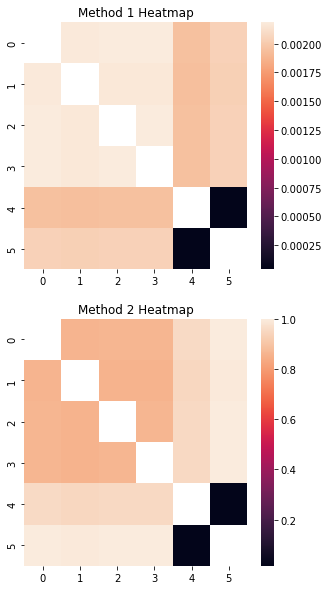

In [23]:
fig, axes = plt.subplots(2, 1)
sns.heatmap(distance_mtxes[0], ax=axes[0]).set_title("Method 1 Heatmap")
sns.heatmap(distance_mtxes[1], ax=axes[1]).set_title("Method 2 Heatmap")

fig.set_size_inches(5, 10)
fig.show()

可以看到，方案2包含的信息更多一些，所以下面使用方案2计算的距离矩阵。
但是，方案2的问题在于**时间成本很高**，因此还需要再考虑

In [24]:
distance_mtx = np.nan_to_num(distance_mtxes[1], nan=10.0)

# 距离矩阵-相对坐标的转换与聚类
- 使用MDS将距离矩阵转换为相对坐标。
- 比较了DBSCAN、KMeans、高斯混合模型的效果差异

C:\Users\zjm97\Anaconda3\envs\torch_env\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


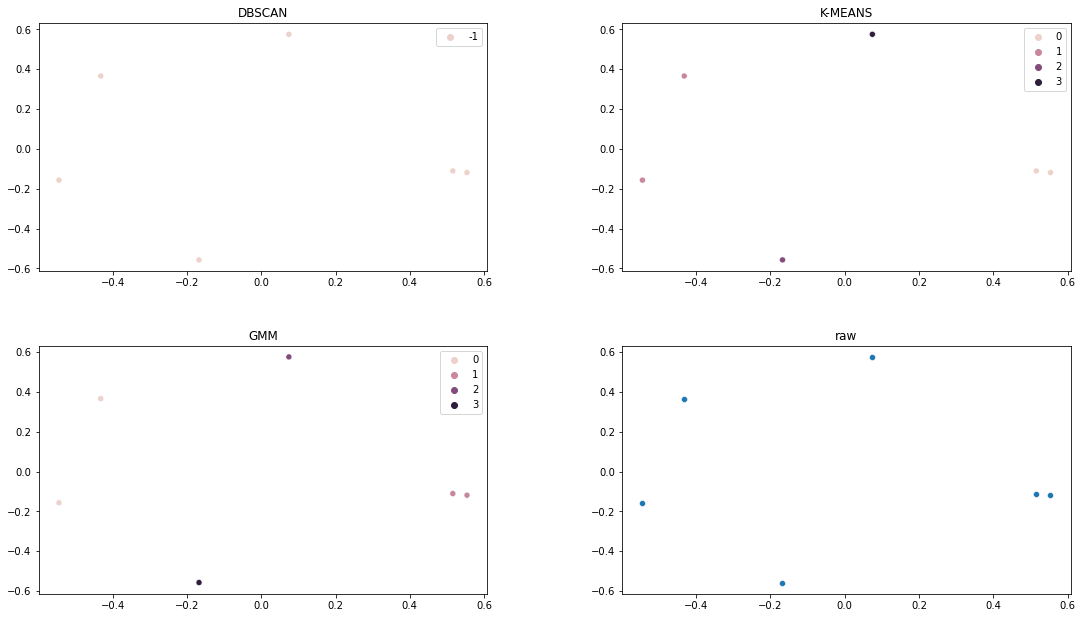

In [25]:
from sklearn.manifold import MDS
from sklearn.cluster import KMeans,DBSCAN
from sklearn.mixture import GaussianMixture




def show_compare(col_embedding,clusters=3,eps=0.2):
    dbscan=DBSCAN(eps=eps).fit_predict(col_embedding)
    kmeans = KMeans(n_clusters=clusters).fit_predict(col_embedding)
    gmm = GaussianMixture(n_components=clusters).fit_predict(col_embedding)

    fig,axes=plt.subplots(2,2)

    p1=sns.scatterplot(x=col_embedding[:, 0], y=col_embedding[:, 1], hue=dbscan,ax=axes[0][0])
    p1.set_title("DBSCAN")
    p2=sns.scatterplot(x=col_embedding[:, 0], y=col_embedding[:, 1], hue=kmeans,ax=axes[0][1])
    p2.set_title("K-MEANS")
    p3=sns.scatterplot(x=col_embedding[:, 0], y=col_embedding[:, 1], hue=gmm,ax=axes[1][0])
    p3.set_title("GMM")
    p4=sns.scatterplot(x=col_embedding[:, 0], y=col_embedding[:, 1],ax=axes[1][1])
    p4.set_title("raw")

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    fig.set_size_inches(18.5,10.5)
    fig.show()


pos = MDS(dissimilarity="precomputed").fit_transform(distance_mtx)
show_compare(pos, clusters=4)


## 估计最佳的高斯混合模型聚类数

C:\Users\zjm97\Anaconda3\envs\torch_env\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "
C:\Users\zjm97\Anaconda3\envs\torch_env\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\zjm97\Anaconda3\envs\torch_env\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretati

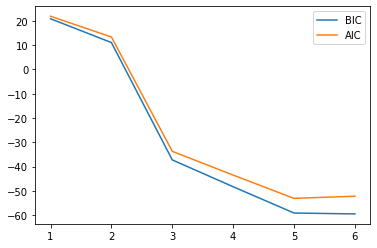

'The best param for n is 5'

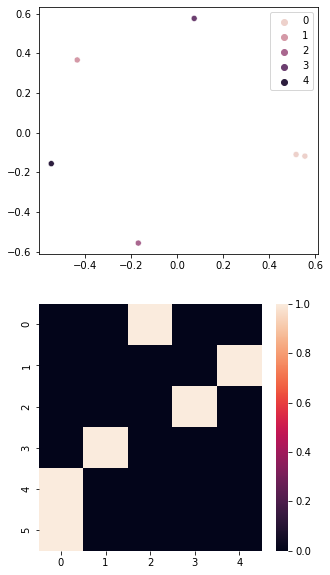

In [30]:
def auto_choose_components(points,lower_n,higher_n):
    models=[GaussianMixture(n_components=n).fit(points) for n in range(lower_n,higher_n+1)]
    BICs = [m.bic(points) for m in models]
    AICs = [m.aic(points) for m in models]
    sns.lineplot(range(lower_n,higher_n+1),BICs,label="BIC")
    sns.lineplot(range(lower_n,higher_n+1),AICs,label="AIC")
    plt.show()
    best_model_idx = min(np.argmin(BICs),np.argmin(AICs))
    return best_model_idx+lower_n,models[best_model_idx]

best_n,best_gmm=auto_choose_components(pos,1,col_nums)
fig,axes = plt.subplots(2,1)
sns.scatterplot(x=pos[:, 0], y=pos[:, 1], hue=best_gmm.predict(pos),ax=axes[0])
sns.heatmap(best_gmm.predict_proba(pos),ax=axes[1])
display(f"The best param for n is {best_n}")
fig.set_size_inches(5,10)

In [27]:
src_table

,date,division,home_team,away_team,home_score,away_score
0,2013-07-20,Österreichische Bundesliga,FK Austria Wien,FC Admira Wacker,2.0,0.0
1,2013-07-20,Österreichische Bundesliga,SC Wiener Neustadt,FC RB Salzburg,1.0,5.0
2,2013-07-20,Österreichische Bundesliga,SV Grodig,SV Ried,0.0,0.0
3,2013-07-20,Österreichische Bundesliga,Wolfsberger AC,SK Rapid Wien,2.0,2.0
4,2013-07-21,Österreichische Bundesliga,FC Wacker Innsbruck,SK Sturm Graz,2.0,2.0
...,...,...,...,...,...,...
6503,2017-05-28,Serie A,Cagliari,Milan,2.0,1.0
6504,2017-05-28,Serie A,Sampdoria,Napoli,2.0,4.0
6505,2017-05-28,Serie A,Fiorentina,Pescara,2.0,2.0
6506,2017-05-28,Serie A,Torino,Sassuolo,5.0,3.0
